<a href="https://colab.research.google.com/github/liuchiente/Digital_Image_Process_at_NCHU/blob/main/Realtime_Fruits_fresh_and_rotten_for_classification_with_Yolov4_%E4%BD%BF%E7%94%A8Yolov4%E5%81%B5%E6%B8%AC%E6%B0%B4%E6%9E%9C%E6%98%AF%E5%90%A6%E8%85%90%E7%88%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 環境初始化


1.   切換到工作目錄
2.   載入會用到的工具函式
3.   準備資料集

In [ ]:
#掛載Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#載入框架和工具函式
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import zipfile
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#載入框架和工具函式,因應OpenCV使用,後面標記圖片會用到
import cv2
import numpy as np
import glob
from google.colab.patches import cv2_imshow

In [ ]:
#切換預設目錄
SYS_DIR = "/content/drive/My Drive/Colab Notebooks/Yololo"
if not os.path.isdir(SYS_DIR):
    os.mkdir(SYS_DIR)
os.chdir(SYS_DIR)

In [ ]:
#確認所在目錄
!ls

In [ ]:
#確認運作環境,GPU情況
!nvidia-smi

Wed Dec 29 01:23:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 準備資料集


本次準備的是從Kaggle上取得的腐爛、新鮮水果資料集, 資料集包含蘋果、香蕉、橘子等腐爛和新鮮的對比,詳情可見Kaggle網址: https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification


In [ ]:
#為了能取得Kaggle資料及,需先下載Kagle套件
! pip install -q kaggle

In [ ]:
#上傳你在Kaggle上取得的認證Token
from google.colab import files

files.upload()

In [ ]:
 # 在根目錄建立Kaggle資料夾
 ! mkdir ~/.kaggle

In [ ]:
 # 複製認證Token到資料夾中,後續呼叫Kaggle套件時會經過此認證
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 查看這個Kaggle帳號所有可見的資料集
!kaggle datasets list

In [ ]:
# 尋找特定的資料集
!kaggle datasets list -s dogs

In [ ]:
# 下載資料集
! kaggle datasets download 'sriramr/fruits-fresh-and-rotten-for-classification'

100% 3.58G/3.58G [00:56<00:00, 112MB/s]
100% 3.58G/3.58G [00:57<00:00, 67.2MB/s]


In [ ]:
# 解壓縮資料集
!unzip fruits-fresh-and-rotten-for-classification.zip

In [ ]:
# 或是可以下載特定競賽的資料集
! kaggle competitions download -c 'name-of-competition'

## 資料預先處理
因為這批資料起碼有一萬張以上圖片,若逐張標記的話可能要花很多時間,所以使用Open CV來做批次處理。 

1.   確認圖片有沒有異常
2.   對圖片進行標記,劃出區域


In [ ]:
# 定義找出bounding box
def get_imgage_range(img_path):
  img = cv2.imread(img_path)
  #把原始圖片轉HSV
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  #設定閥值,把圖片轉為二值化圖片,在後續轉換中,閥值以上為1,閥值以下為0
  lower = np.array([0, 0, 0], dtype = "uint8")
  upper = np.array([255, 50, 255], dtype = "uint8")
  #轉換為二值化圖片
  img = cv2.inRange(img, lower, upper)
  #平均濾波去雜訊
  img = cv2.blur(img, (2, 2))
  #因為平均濾波後,圖片會失去二值化效果,所以再做一次二值化
  ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
  #把圖片做NOT,凸顯出輪廓內的本體
  img = cv2.bitwise_not(img)
  #找出物體
  contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = max(contours, key=lambda x: cv2.contourArea(x))
  #取得方框位置
  x, y, w, h = cv2.boundingRect(contours)
  
  #計算四個角的x,y位置
  xmin=x
  ymin=y
  xmax=x+w
  ymax=y+h

  #找出圖片尺寸
  dimensions = img.shape
  hi = img.shape[0]
  wi = img.shape[1]
  
  #計算Open CV所需要的比例,劃出bounding box
  xp = (xmin + (xmax-xmin)/2) * 1.0 / wi
  yp = (ymin + (ymax-ymin)/2) * 1.0 / hi
  wp = (xmax-xmin) * 1.0 / wi
  hp = (ymax-ymin) * 1.0 / hi
  return xp, yp, wp, hp

In [ ]:
#看一下當下目錄
!ls

3rdparty	   darknet53.conv.74.1	   libdarknet.so    rot
backup		   DarknetConfig.cmake.in  LICENSE	    scripts
bad.list	   darknet_images.py	   Makefile	    simon.jpg
build		   darknet.py		   net_cam_v3.sh    src
build.ps1	   darknet_video.py	   net_cam_v4.sh    uselib
cfg		   data			   obj		    vcpkg.json
cmake		   image_yolov3.sh	   predictions.jpg  video_yolov3.sh
CMakeLists.txt	   image_yolov4.sh	   __pycache__	    video_yolov4.sh
darknet		   include		   README.md	    yolov4-tiny.weights
darknet53.conv.74  json_mjpeg_streams.sh   results	    yolov4.weights


In [ ]:
# 首先清除上次做Yolo訓練時需要的Train、Test的圖片路徑紀錄文字檔
if os.path.exists('./darknet/rot/train.txt'):
  os.remove('./darknet/rot/train.txt')
if os.path.exists('./darknet/rot/text.txt'):
  os.remove('./darknet/rot/text.txt')

In [ ]:
#重新訓練或是一開始訓練時,我會先刪除原本的標籤檔案
for dirname, _, filenames in os.walk('./darknet/rot/dataset'):
    counter=0
    for filename in  glob.iglob(dirname+'/*.txt') :
      os.remove(filename)      

In [ ]:
#確認是不是有圖片檔案路徑異常,造成沒辦法讀取到圖片
for dirname, _, filenames in os.walk('./rot/dataset'):
    for img_path in  glob.iglob(dirname+'/*.png') :
      if not os.path.exists(img_path):
        print(img_path)
        os.remove(img_path) 

In [ ]:
#開始遍歷資料夾裡面的圖片,並為它加上標籤
imgcnt=0
for dirname, _, filenames in os.walk('./rot/dataset'):
    for img_path in  glob.iglob(dirname+'/*.png') :

        lbl_path=os.path.splitext(img_path)[0]+".txt"
        dirnames=dirname.split('/')

        if len(dirnames)>4:
          #定義標籤
          label=0
          if dirnames[4] == 'freshapples':
            label=0
          elif dirnames[4] == 'freshbanana':
            label=1
          elif dirnames[4] == 'freshoranges':
            label=2
          elif dirnames[4] == 'rottenapples':
            label=3
          elif dirnames[4] == 'rottenbanana':
            label=4
          elif dirnames[4] == 'rottenoranges':
            label=5
  
          #轉換Yolo需要的標記格式
          if os.path.exists(img_path):
              #取得標籤
              xmin, ymin, xmax, ymax=get_imgage_range(img_path)
              #儲存標籤
              with open(lbl_path, 'a+') as f:
                f.write('%s %s %s %s %s\n' % (label,xmin, ymin, xmax, ymax))
              #紀錄Train、Text路徑
              with open('./rot/'+dirnames[3]+ '.txt', 'a+') as f:
                line_txt = [img_path, '\n']
                f.writelines(line_txt)
              imgcnt=imgcnt+1
          else:
            print(img_path)

In [ ]:
#標記結果
print(str(imgcnt)+" images had been processed")

13319 images had been processed


## 準備Yolov4模型

1.   下載Yolo框架
2.   下載預訓練模型
3.   建立設定檔案

### 建立自己要用的設定檔時,需要調整cfg檔,在本次訓練中,我新增了6個label,故cfg檔中的classes須調整為6,而filter則應該是6+4+1*3=33個filter。

In [ ]:
#安裝 Yolo V4
!git clone https://github.com/AlexeyAB/darknet.git

In [ ]:
%cd ./darknet

/content/drive/My Drive/Colab Notebooks/Yololo/darknet


In [ ]:
!chmod +x ./darknet

In [ ]:
#修改Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
#打包建立框架
!make

In [ ]:
# 下載 yolov4-tiny
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights

In [ ]:
# 下載 yolov4
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
#下載預訓練模型
!wget https://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
# 建立Yolo設定檔,複製原有的記錄檔過來做修改
import os
import shutil
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Yololo/rot"):
 os.mkdir("/content/drive/MyDrive/Colab Notebooks/Yololo/rot")
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg"):
 os.mkdir("/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg") 
 os.mkdir("/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg/weights")
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg/fruit.data"):
 shutil.copyfile("/content/drive/MyDrive/Colab Notebooks/Yololo/darknet/cfg/coco.data", "/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg/fruit.data")
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg/fruit.names"):
 shutil.copyfile("/content/drive/MyDrive/Colab Notebooks/Yololo/darknet/cfg/coco.names", "/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg/fruit.names")


In [ ]:
# 建立Yolo設定檔,複製原有的記錄檔過來做修改,　因為Colab跑不太動,所以用yolov4-tiny.cfg減少傳入的batch數,好完成訓練。
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg/yolov4-tiny.cfgg"):
 shutil.copyfile("/content/drive/MyDrive/Colab Notebooks/Yololo/darknet/cfg/yolov4-tiny.cfg", "/content/drive/MyDrive/Colab Notebooks/Yololo/rot/cfg/yolov4-tiny.cfg")


## 訓練Yolov4模型

1.   須注意前述的設定問題
2.   使用網路上抓下來的預訓練模型,可以增加辨識能力
3.   另外須注意引用的cfg,如果丟入的訓練batch太大,colab的記憶體會爆炸

In [ ]:
!ls

In [ ]:
# 訓練
!./darknet detector train ./rot/cfg/fruit.data ./rot/cfg/yolov4-tiny.cfg ./darknet53.conv.74 -dont_show

串流輸出內容已截斷至最後 5000 行。
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.890475), count: 64, class_loss = 0.238471, iou_loss = 0.059634, total_loss = 0.298104 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.461161), count: 1, class_loss = 0.008504, iou_loss = 0.001821, total_loss = 0.010325 
 total_bbox = 1117897, rewritten_bbox = 0.000000 % 

 17432: 0.123842, 0.132930 avg loss, 0.002610 rate, 1.184425 seconds, 1115648 images, 636.529510 hours left
Loaded: 0.000077 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.857510), count: 64, class_loss = 0.239782, iou_loss = 0.063344, total_loss = 0.303126 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000137, iou_loss = 0.000000, total_loss = 0.000137 
 total_bbox = 1117961, rewritten_bbox = 0.000000 % 

 17433: 0.120037, 0.131641 avg loss, 0.002610 rate, 1.135724 secon

In [ ]:
# 測試效果
!./darknet detector test ./rot/cfg/fruit.data ./rot/cfg/yolov4-tiny.cfg ./rot/cfg/weights/yolov4-tiny_last.weights ./rot/qoo.png -i 0 -thresh 0.25

## 測試實際運作效果

1.   引用darknet函式庫
2.   搭配javascript,並打開瀏覽器取用鏡頭的權限,就可以輸入影像

In [ ]:
# 引用函式庫
import cv2
import matplotlib.pyplot as plt

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt

# 讓 matplot 圖表顯示在Jupyter Notebook裡面
%matplotlib inline

from darknet import *

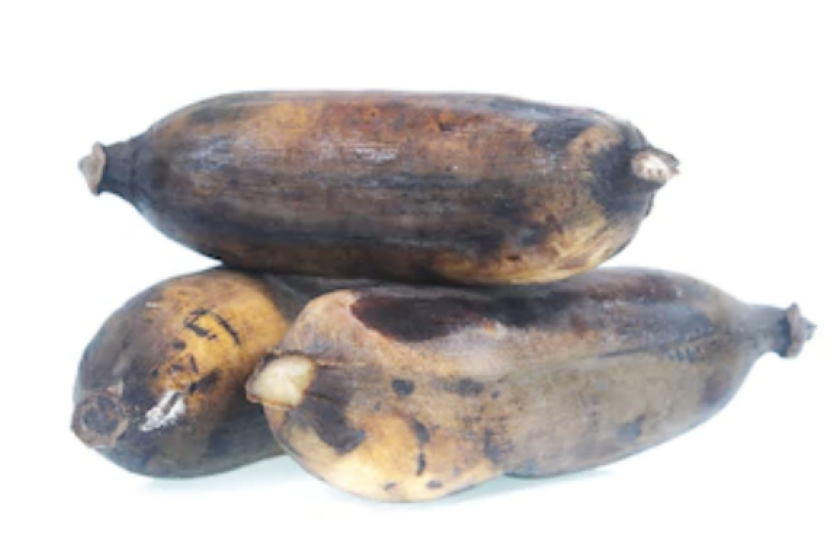

In [ ]:
# 查看測試目標的標記結果

# 透過OpenCV讀取圖片
path = './rot/qoo.png'
img = cv2.imread(path)
  
# 在 Jupyter Notebook 上需要轉換成 Matplot 顯示才行

fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 引用darknet的函式庫,後續用來結合Colab做顯示,須注意使用這個功能時,當下目錄需在darknet底下


# load in our YOLOv4 architecture network
#network, class_names, class_colors = load_network("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
network, class_names, class_colors = load_network("rot/cfg/yolov4-tiny.cfg", "rot/cfg/fruit.data", "yolov4-tiny_last.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image

def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  
# get image ratios to convert bounding boxes to proper size

  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  
# run model on darknet style image to get detections

  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio


In [ ]:
#引用Javascript,從瀏覽器輸入影像後,進行即時影像辨識

# function to convert the JavaScript object into an OpenCV image

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  
# decode base64 image

  image_bytes = b64decode(js_reply.split(',')[1])
  
# convert bytes to numpy array

  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  
# decode numpy array into OpenCV BGR image

  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  
# convert array into PIL image

  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  
# format bbox into png for return

  bbox_PIL.save(iobuf, format='png')
  
# format return string

  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# JavaScript to properly create our live video stream using our webcam as input

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# 開啟影像串流

video_stream()
# 標題

label_html = 'Capturing...'
# 初始化參數

bbox = ''
count = 0 

while True:

  
# 顯示並取得影像

  js_reply = video_frame(label_html, bbox)
  if not js_reply:
      break

# 將影像轉換成OpenCV的格式

  frame = js_to_image(js_reply["img"])

  
# 建立邊界框的底圖

  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  
# 進行辨識

  detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

  
# 繪製邊界框於剛剛建立的bbox_array

  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
    bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)

  bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
  
# 將 bbox_array轉換成可以輸入到畫面上的 byte 格式

  bbox_bytes = bbox_to_bytes(bbox_array)
  
  
# 更新bbox這樣下一次畫面中的畫面才會更新

  bbox = bbox_bytes